In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm
from mamba_ssm import Mamba


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature columns
feature_cols = [
    "year",
    "membership_year",
    "is_household",
    "vehicle_count",
    "vehicle_age_mean",
    "beløp",
    "gave_feedback",
    "mean_feedback",
    "age",
    "gender",
    "sentralitetsindex",
]

# Load the examples
train_examples = torch.load("all/train_examples.pt")
val_examples = torch.load("all/val_examples.pt")

In [ ]:
# 4. Dataset & DataLoader
class ChurnDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        seq, length, label = self.examples[idx]
        return seq, length, label


def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    # pad to the max seq‐len in the batch
    seqs_padded = pad_sequence(seqs, batch_first=True)  # [B, T, F]
    lengths = torch.tensor(lengths, dtype=torch.long)  # [B]
    labels = torch.tensor(labels, dtype=torch.long)  # [B]
    # build an attention mask: True == padding
    max_len = seqs_padded.size(1)
    # shape [B, T]: for each example, positions >= length are padding
    attn_mask = torch.arange(max_len, device=lengths.device).unsqueeze(0).expand(
        len(lengths), -1
    ) >= lengths.unsqueeze(1)
    return (
        seqs_padded.to(device),
        lengths.to(device),
        attn_mask.to(device),
        labels.to(device),
    )


train_ds = ChurnDataset(train_examples)
val_ds = ChurnDataset(val_examples)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
# 5. Model
torch.manual_seed(42)


class MambaClassifier(nn.Module):
    def __init__(self, input_size, d_model, n_layers, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model)

        # Stack of Mamba layers
        self.mamba_blocks = nn.ModuleList(
            [
                Mamba(
                    d_model=d_model,
                    d_state=16,  # usually 1/4th of d_model
                    d_conv=4,  # convolution kernel size
                    expand_factor=2,  # internal expansion
                )
                for _ in range(n_layers)
            ]
        )

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, lengths, attn_mask):
        x = self.embedding(x)  # [B, T, d_model]

        for layer in self.mamba_blocks:
            x = layer(x)  # [B, T, d_model]

        # Use the last valid (non-padding) token
        batch_size = x.size(0)
        last_valid_indices = lengths - 1
        last_token_repr = x[torch.arange(batch_size), last_valid_indices]

        out = self.fc(last_token_repr)
        return out


# Instantiate model
input_size = len(feature_cols)
d_model = 64  # Internal hidden size
n_layers = 2  # How many Mamba layers
num_classes = 3  # Your churn horizon classes: 0/1/2

model = MambaClassifier(input_size, d_model, n_layers, num_classes).to(device)


# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/root/nielsen/informer-test/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
import wandb

num_epochs = 50

wandb.init(project="churn", name="lstm")

# 6. Training & Evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Train")
    for seqs, lengths, attn_mask, labels in loop:
        optimizer.zero_grad()
        outputs = model(seqs, lengths, attn_mask)  # <-- add attn_mask here
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Val")
    with torch.no_grad():
        for seqs, lengths, attn_mask, labels in loop:
            outputs = model(seqs, lengths, attn_mask)  # <-- add attn_mask here
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


# Run training
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(
        f"Epoch {epoch:>2d}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )
    
    # Log to wandb
    wandb.log(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        }
    )
    
wandb.finish()

Val: 100%|██████████| 2351/2351 [00:05<00:00, 461.77it/s, acc=0.518, loss=0.86] 


Epoch  1: train_loss=0.9357, train_acc=0.5189 | val_loss=0.9225, val_acc=0.5185


Val: 100%|██████████| 2351/2351 [00:05<00:00, 460.16it/s, acc=0.542, loss=0.837]


Epoch  2: train_loss=0.9128, train_acc=0.5336 | val_loss=0.9014, val_acc=0.5419


Val: 100%|██████████| 2351/2351 [00:03<00:00, 677.18it/s, acc=0.543, loss=0.806]


Epoch  3: train_loss=0.9057, train_acc=0.5375 | val_loss=0.9000, val_acc=0.5428


Val: 100%|██████████| 2351/2351 [00:03<00:00, 602.42it/s, acc=0.542, loss=0.835]


Epoch  4: train_loss=0.9025, train_acc=0.5397 | val_loss=0.8991, val_acc=0.5423


Val: 100%|██████████| 2351/2351 [00:05<00:00, 468.87it/s, acc=0.539, loss=0.829]


Epoch  5: train_loss=0.9000, train_acc=0.5415 | val_loss=0.9013, val_acc=0.5394


Val: 100%|██████████| 2351/2351 [00:06<00:00, 377.20it/s, acc=0.545, loss=0.788]


Epoch  6: train_loss=0.8979, train_acc=0.5418 | val_loss=0.8927, val_acc=0.5455


Val: 100%|██████████| 2351/2351 [00:05<00:00, 397.62it/s, acc=0.544, loss=0.837]


Epoch  7: train_loss=0.8967, train_acc=0.5431 | val_loss=0.8916, val_acc=0.5442


Val: 100%|██████████| 2351/2351 [00:20<00:00, 116.38it/s, acc=0.543, loss=0.828]


Epoch  8: train_loss=0.8959, train_acc=0.5434 | val_loss=0.8936, val_acc=0.5431


Val: 100%|██████████| 2351/2351 [00:05<00:00, 443.45it/s, acc=0.544, loss=0.792]


Epoch  9: train_loss=0.8946, train_acc=0.5441 | val_loss=0.8920, val_acc=0.5438


Val: 100%|██████████| 2351/2351 [00:05<00:00, 404.19it/s, acc=0.545, loss=0.803]


Epoch 10: train_loss=0.8942, train_acc=0.5443 | val_loss=0.8930, val_acc=0.5445


Val: 100%|██████████| 2351/2351 [00:05<00:00, 392.32it/s, acc=0.545, loss=0.813]


Epoch 11: train_loss=0.8936, train_acc=0.5443 | val_loss=0.8953, val_acc=0.5455


Val: 100%|██████████| 2351/2351 [00:06<00:00, 385.66it/s, acc=0.549, loss=0.789]


Epoch 12: train_loss=0.8931, train_acc=0.5452 | val_loss=0.8869, val_acc=0.5492


Val: 100%|██████████| 2351/2351 [00:05<00:00, 405.46it/s, acc=0.549, loss=0.833]


Epoch 13: train_loss=0.8923, train_acc=0.5456 | val_loss=0.8896, val_acc=0.5486


Val: 100%|██████████| 2351/2351 [00:04<00:00, 478.38it/s, acc=0.549, loss=0.827]


Epoch 14: train_loss=0.8918, train_acc=0.5461 | val_loss=0.8899, val_acc=0.5489


Val: 100%|██████████| 2351/2351 [00:03<00:00, 757.69it/s, acc=0.542, loss=0.846]


Epoch 15: train_loss=0.8914, train_acc=0.5453 | val_loss=0.8984, val_acc=0.5421


Val: 100%|██████████| 2351/2351 [00:03<00:00, 717.11it/s, acc=0.543, loss=0.804]


Epoch 16: train_loss=0.8908, train_acc=0.5463 | val_loss=0.9007, val_acc=0.5431


Val: 100%|██████████| 2351/2351 [00:03<00:00, 599.00it/s, acc=0.543, loss=0.8]  


Epoch 17: train_loss=0.8900, train_acc=0.5470 | val_loss=0.8960, val_acc=0.5428


Val: 100%|██████████| 2351/2351 [00:13<00:00, 168.22it/s, acc=0.549, loss=0.806] 


Epoch 18: train_loss=0.8900, train_acc=0.5459 | val_loss=0.8853, val_acc=0.5492


Val: 100%|██████████| 2351/2351 [00:02<00:00, 1090.56it/s, acc=0.538, loss=0.809]


Epoch 19: train_loss=0.8895, train_acc=0.5464 | val_loss=0.8933, val_acc=0.5380


Val: 100%|██████████| 2351/2351 [00:02<00:00, 1078.15it/s, acc=0.546, loss=0.843]


Epoch 20: train_loss=0.8896, train_acc=0.5461 | val_loss=0.8939, val_acc=0.5457


ROC AUC Score (OvR): 0.7321

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.56      0.54     21127
           1       0.62      0.63      0.62     34706
           2       0.43      0.39      0.41     19394

    accuracy                           0.55     75227
   macro avg       0.52      0.52      0.52     75227
weighted avg       0.54      0.55      0.54     75227



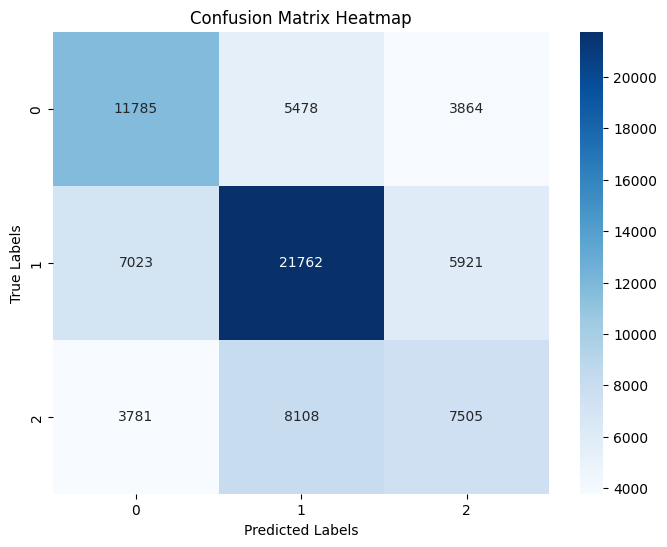

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Collect all true labels and predicted probabilities
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for seqs, lengths, attn_mask, labels in tqdm(
        val_loader, desc="Collecting predictions"
    ):
        outputs = model(seqs, lengths, attn_mask)  # <-- add attn_mask here
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

# 2. ROC AUC Score (one-vs-rest for multiclass)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

# 3. Classification Report
report = classification_report(all_labels, all_preds)
print("\nClassification Report:\n", report)

# 4. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()